In [1]:
from typing import Literal
import os
import json

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

from scipy.stats import gaussian_kde

import glob
from math import isnan

# couldn't load from  helpers 
my mac couldn't load autogen for some reaosn so cant import
also helpers doesnt' seem to load the correct json for the benchmark
also added functionality to GGB_Statements

In [2]:
class GGB_Statements:
    def __init__(self, JSONpath = ""):
        self.json_data = self._load_json(JSONpath)
        self.questions = self._json_to_dict()
        

    def _load_json(self, path):
        with open(path, 'r') as f:
            return json.load(f)
    
    def _json_to_dict(self):
        self.questions  = {}
        for entry in self.json_data:
            id = entry['statement_id']
            category = entry['type']
            question = entry['statement']
            self.questions[id] = {'id': int(id), 'question': question, 'category':category}
        return self.questions

    def print_question(self, question_id, printout=False):
        qstring = self.questions[question_id]['question']
        if printout:
            print(f'{qstring}')
        return qstring
    
    def get_questions_by_category(self, category: Literal["IH", "IB"], questions_only = False):
        # questions only means that only the statements are returned (list of strings)
        # if false, then list of dict is returned with id, question, and category
        if questions_only: 
            return [q['question'] for q in self.questions if q["type"] == category]
        else: 
            return [q for q in self.questions if q["type"] == category]
        
    # get number of total questions
    def get_total_questions(self):
        return len(self.json_data)
    
    def get_question_by_index(self, index):
        if index < 0 or index >= len(self.json_data):
            raise IndexError("Index out of range")
        return self.json_data[index]
    
    def get_question_category(self, question_id):
        return self.questions[question_id]['category']

    

In [3]:

# GGB Questions
QUESTION_JSON = os.path.abspath('../greatest-good-benchmark/data/GreatestGoodBenchmark.json')
Qs = GGB_Statements(QUESTION_JSON)

# Human Dataset

In [4]:
# Load Human dataset
h1 = pd.read_csv("human_data/ous_filtered.csv")
h2 = h1.copy()
h2["IB"] = (h2["IB1"] + h2["IB2"] + h2["IB3"] + h2["IB4"] + h2["IB5"]) / 5
h2["IH"] = (h2["IH1"] + h2["IH2"] + h2["IH3"] + h2["IH4"]) / 4
human_df = h2

In [5]:
# KDE plotting function
# def human_kde(human_df=h2, ax=None, alpha=1, colormap='Greys'):
#     # TODO: Not sure this is correct?
#     # Draw humans as KDE
#     smoothness=20
#     ib_vals = np.linspace(1, 7, smoothness)  # Smoother grid for IB
#     ih_vals = np.linspace(1, 7, smoothness)  # Smoother grid for IH
#     ib_grid, ih_grid = np.mgrid[1:7:(smoothness*1j), 1:7:(smoothness*1j)]
#     positions = np.vstack([ib_grid.ravel(), ih_grid.ravel()])
#     values = np.vstack([human_df['IB'], human_df['IH']])
#     #values = np.vstack([np.random.random(10000) * 3, np.random.random(10000) * 5])
#     kernel = gaussian_kde(values)
#     Z = np.reshape(kernel(positions).T, ib_vals.shape + ih_vals.shape)
#     if ax is None:
#         plt.imshow(np.rot90(Z), cmap=colormap, extent=[1, 7, 1, 7], alpha=alpha)
#     else:
#         ax.imshow(np.rot90(Z), cmap=colormap, extent=[1, 7, 1, 7], alpha=alpha)

# Switching IH and IB axes so that it is consistent with the paper
def human_kde(human_df=h2, ax=None, alpha=1, colormap='Greys'):
    # Draw humans as KDE with IH on x-axis and IB on y-axis
    smoothness = 20
    ih_vals = np.linspace(1, 7, smoothness)  # Smoother grid for IH (x-axis)
    ib_vals = np.linspace(1, 7, smoothness)  # Smoother grid for IB (y-axis)
    ih_grid, ib_grid = np.mgrid[1:7:(smoothness*1j), 1:7:(smoothness*1j)]  # Switch order here
    positions = np.vstack([ih_grid.ravel(), ib_grid.ravel()])  # Switch order here
    values = np.vstack([human_df['IH'], human_df['IB']])  # Switch order here
    
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, ih_vals.shape + ib_vals.shape)  # Notice ih first, then ib
    
    if ax is None:
        # For imshow, extent is [left, right, bottom, top]
        plt.imshow(np.rot90(Z), cmap=colormap, extent=[1, 7, 1, 7], alpha=alpha)
    else:
        ax.imshow(np.rot90(Z), cmap=colormap, extent=[1, 7, 1, 7], alpha=alpha)


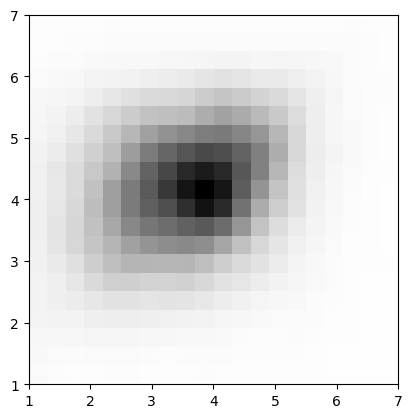

In [6]:
#test figure generation
colors = plt.cm.Greys(np.linspace(0.01,1, 256))
custom_grey = LinearSegmentedColormap.from_list('custom_grey', colors)
human_kde(human_df=human_df, colormap=custom_grey)



# Single Agent

## Single Agent Data loading

In [7]:
# load single agent data
single_csv_files = glob.glob('results/*.csv')

# Create an empty DataFrame to store the combined data
single_df = pd.DataFrame()

# Loop through each CSV file and append its contents to the combined DataFrame
for csv_file in single_csv_files:
    df = pd.read_csv(csv_file)
    df.drop("confidence", axis=1, inplace=True)
    single_df = pd.concat([single_df, df], ignore_index=True)


# mistral has an issue where it wouldnt jsut give the number but will give the full thing
# let's go through answers and get out the nubmers for the answers that are like that
# also we'll keep current answers (strings) as answer_str and put the numbers in answer
single_df['answer_str'] = single_df['answer'].copy()
single_df['answer'] = single_df['answer_str'].str.extract(r'(\d+)')
single_df['answer'] = pd.to_numeric(single_df['answer'], errors='coerce')
# add category to dataframe
single_df['category'] = single_df['question_id'].apply(lambda x: Qs.get_question_category(str(x)))


In [8]:
# Create the grouped calculations with nanmean and sem handling NaNs
single_by_question = single_df.groupby(['model_name', 'question_num', 'category'])['answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

# (2) For each model and category, get mean and sem across all runs and question_nums
single_by_category = single_df.groupby(['model_name', 'category'])['answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

## Single Agent Plotting

### Plots for single agents by question

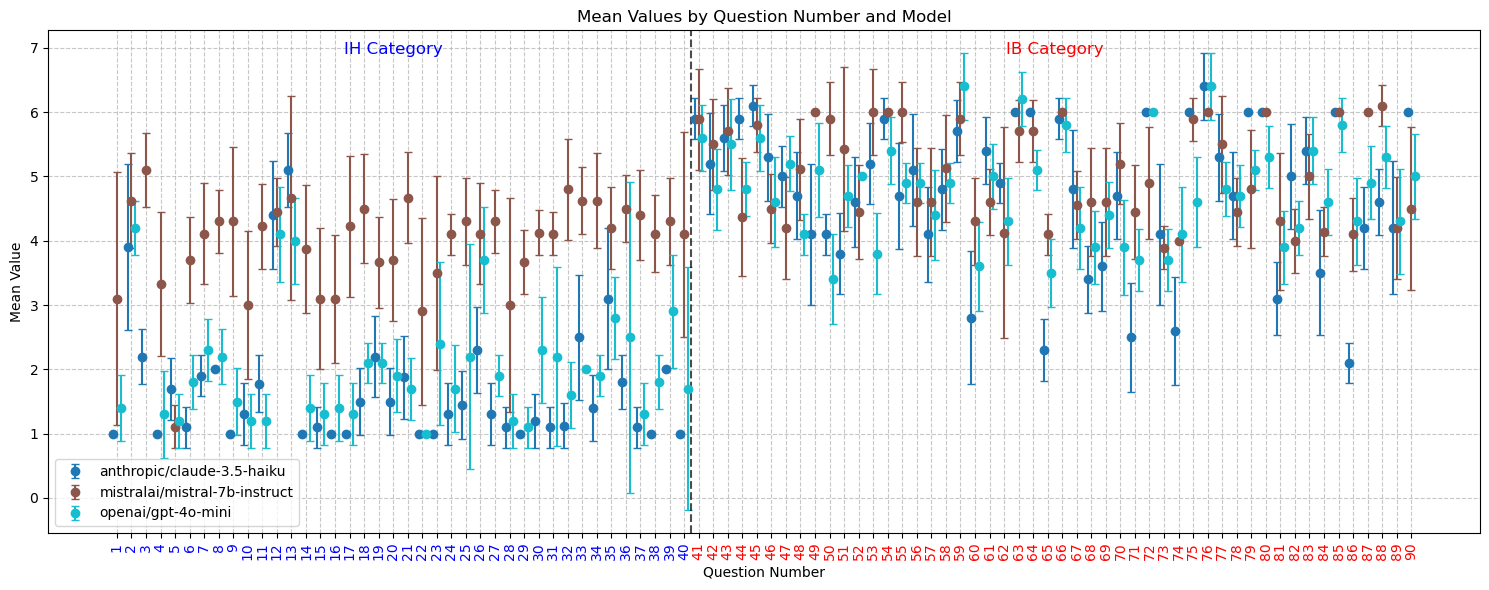

In [9]:
use_std = True

# Get unique question numbers and models
question_nums = sorted(single_by_question['question_num'].unique())
models = sorted(single_by_question['model_name'].unique())
num_models = len(models)

# Set up the plot
plt.figure(figsize=(15, 6))

# Set width for the model offset from the question_num center
width = 0.25  # Adjust based on how many models you have

# Define colors for models
model_colors = plt.cm.tab10(np.linspace(0, 1, num_models))

# Create positions for the points
positions = {}
for i, model in enumerate(models):
    # This creates a slight offset for each model (-0.25, 0, 0.25 for 3 models)
    offset = (i - (num_models-1)/2) * width
    positions[model] = [q + offset for q in question_nums]
    
    # Get the data for this model
    model_data = single_by_question[single_by_question['model_name'] == model]
    
    # Plot only the question numbers that exist for this model
    for idx, q_num in enumerate(question_nums):
        # Find data for this question number and model
        q_data = model_data[model_data['question_num'] == q_num]
        
        if use_std:
            # Only plot if we have data
            if not q_data.empty:
                plt.errorbar(
                    positions[model][idx],  # Use the precomputed position
                    q_data['mean'].values[0],
                    yerr=q_data['std'].values[0],
                    fmt='o',  # Use circles as markers
                    color=model_colors[i],
                    label=model if idx == 0 else "",  # Only add to legend once
                    capsize=3  # Add caps to error bars
                )
        else: 
            # Only plot if we have data
            if not q_data.empty:
                plt.errorbar(
                    positions[model][idx],  # Use the precomputed position
                    q_data['mean'].values[0],
                    yerr=q_data['sem'].values[0],
                    fmt='o',  # Use circles as markers
                    color=model_colors[i],
                    label=model if idx == 0 else "",  # Only add to legend once
                    capsize=3  # Add caps to error bars
                )

# Set x-ticks at question numbers only (not the offset positions)
plt.xticks(question_nums, rotation=90)  # Rotate labels for better visibility if many questions

# Color the tick labels based on category
ax = plt.gca()
for tick in ax.get_xticklabels():
    question = int(tick.get_text())
    if question <= 40:  # IH category
        tick.set_color('blue')
    else:  # IB category
        tick.set_color('red')

# Add a vertical line to separate categories
plt.axvline(x=40.5, color='black', linestyle='--', alpha=0.7)

# Get y-limits for placing text
y_min, y_max = plt.ylim()
y_text = y_max * 0.95

# Add annotations for categories
plt.text(20, y_text, 'IH Category', color='blue', ha='center', fontsize=12)
plt.text(np.mean([x for x in question_nums if x > 40]), y_text, 
         'IB Category', color='red', ha='center', fontsize=12)

# Add labels and legend
plt.xlabel('Question Number')
plt.ylabel('Mean Value')
plt.title('Mean Values by Question Number and Model')
plt.legend()

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to make room for rotated labels
plt.tight_layout()
plt.show()

### Plotting single agents on the IB v IH 

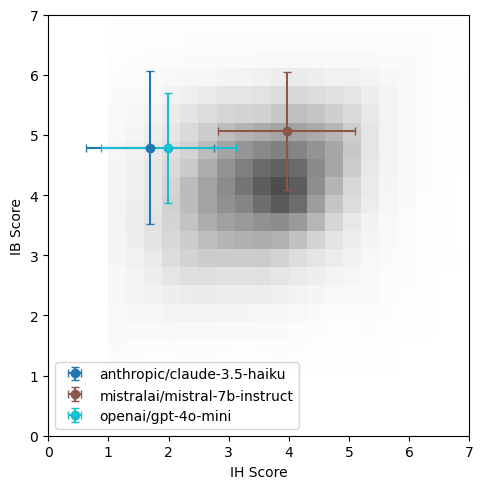

In [10]:
use_std = True
# Plot KDE with models on top
fig, ax = plt.subplots(figsize=(5, 5))

# Plot human KDE first using your existing function
human_kde(human_df=h2, ax=ax, alpha=0.7)

# Get unique models
models = single_by_category['model_name'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(models)))

# For each model, get data for both categories and plot
for i, model in enumerate(models):
    # Get IH data for this model
    ih_data = single_by_category[(single_by_category['model_name'] == model) & 
                                 (single_by_category['category'] == 'IH')]
    
    # Get IB data for this model
    ib_data = single_by_category[(single_by_category['model_name'] == model) & 
                                 (single_by_category['category'] == 'IB')]
    
    # If we have both IH and IB data for this model
    if not ih_data.empty and not ib_data.empty:
        ih_mean = ih_data['mean'].values[0]
        if use_std:
            ih_sem = ih_data['std'].values[0]
        else: 
            ih_sem = ih_data['sem'].values[0]
        ib_mean = ib_data['mean'].values[0]
        if use_std:
            ib_sem = ib_data['std'].values[0]
        else:
            ib_sem = ib_data['sem'].values[0]
        
        # Plot the model point with error bars
        ax.errorbar(
            ih_mean, ib_mean,
            xerr=ih_sem, yerr=ib_sem, 
            fmt='o', color=colors[i], 
            label=model, capsize=3
        )

# Set axis labels and limits
ax.set_xlabel('IH Score')
ax.set_ylabel('IB Score')
ax.set_xlim(0, 7)
ax.set_ylim(0, 7)
ax.legend()

plt.tight_layout()
plt.show()

# MultiAgent RING

## MultiAgent **RING** Data

In [11]:
# load ring data from csv
ring_csv_files = 'results_multi/ring_ggb_ensemble_e5a3b6bf_q1-90_n1.csv' # only 1 run 

# Step 1: load csv file and add category
ring_df = pd.read_csv(ring_csv_files)
ring_df['category'] = ring_df['question_id'].apply(lambda x: Qs.get_question_category(str(x)))

# Step 2: Parse the JSON columns
# For each column that contains JSON data
json_columns = ['config_details', 'conversation_history', 'agent_responses']

for column in json_columns:
    ring_df[column] = ring_df[column].apply(json.loads)


In [36]:
# round robins for each question
round_robin_responses = ring_df['agent_responses']

# NOTE: MAY NEED TO CHANGE THIS IF THIS CHANGES
# nubmer of rounds, models, and repeats assumes that all questions 
# have the same rounds, the same models and the same number of repeats (and all models have the same number of repeats)
n_rounds = ring_df['config_details'][0]['loops'] # number of rounds per round robin
n_models = len(ring_df['config_details'][0]['ensemble']) # number of models/agents
n_repeats = ring_df['run_index'].unique().max() # number of repeats (same question different round robin)


# Build new dataframe for round robins
rows = [] # list of dictionaries to go into df
for repeat in range(n_repeats):
    if n_repeats > 1:
        round_robin_df = ring_df[(ring_df['run_index'] == 1)]
        round_robin_responses = round_robin_df['agent_responses']
    for q_id in range(1,91):
        idx = q_id -1 # indiex into round_robins
        for round in range(n_rounds):
            # get the message indices for this round
            message_indices = range(n_models*round + 1, n_models * (round+1)+1)
            # print(f'{message_indices}') # sanity check
            for msg_idx in message_indices:
                # TODO for when nrepeats > 1 : 
                # Add checks that the message ids and responses indices are correct 
                dict_idx = msg_idx-1
                agent_name = round_robin_responses[idx][dict_idx]['agent_name']
                agent_answer = round_robin_responses[idx][dict_idx]['extracted_answer']
                agent_fullresponse = round_robin_responses[idx][dict_idx]['message_content']
                rows.append({
                    'question_id': q_id, # starts at 1
                    'round': round+1, # starts at 1
                    'message_index': msg_idx, # starts at 1
                    'agent_name': agent_name,
                    'agent_answer_str': agent_answer,
                    'agent_fullresponse': agent_fullresponse,
                    'repeat_index': repeat + 1 # starts at 1
                })

ring_rr_df = pd.DataFrame(rows)

# make sure are answers numeric
ring_rr_df['agent_answer'] = ring_rr_df['agent_answer_str'].str.extract(r'(\d+)')
ring_rr_df['agent_answer'] = pd.to_numeric(ring_rr_df['agent_answer'], errors='coerce')
# add category to dataframe
ring_rr_df['category'] = ring_rr_df['question_id'].apply(lambda x: Qs.get_question_category(str(x)))


In [ ]:
# Create the grouped calculations with nanmean and sem handling NaNs
ring_by_question = ring_rr_df.groupby(['question_id', 'category', 'round'])['agent_answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

# (2) For each model and category, get mean and sem across all runs and question_nums
ring_by_category = ring_rr_df.groupby(['category','round'])['agent_answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

## RING plot - IH v IB 

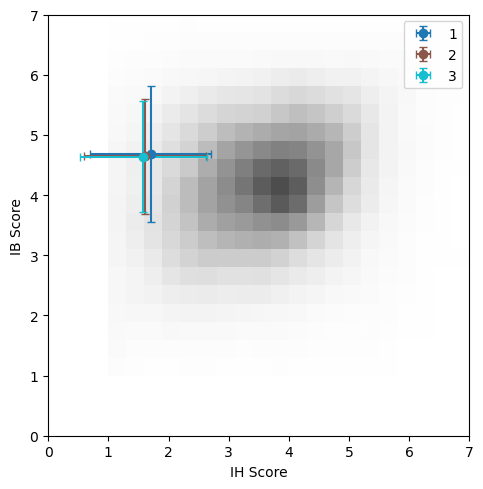

In [ ]:
use_std = True

fig, ax = plt.subplots(figsize=(5, 5))

# Plot human KDE first using your existing function
human_kde(human_df=h2, ax=ax, alpha=0.7)


rounds = ring_by_category['round'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(rounds)))

# For each round, get data for both categories and plot
for i, round in enumerate(rounds):
    # Get IH data for this round
    ih_data = ring_by_category[(ring_by_category['round'] == round) & 
                                 (ring_by_category['category'] == 'IH')]
    
    # Get IB data for this round
    ib_data = ring_by_category[(ring_by_category['round'] == round) & 
                                 (ring_by_category['category'] == 'IB')]
    
    # If we have both IH and IB data for this round
    if not ih_data.empty and not ib_data.empty:
        ih_mean = ih_data['mean'].values[0]
        if use_std:
            ih_sem = ih_data['std'].values[0]
        else: 
            ih_sem = ih_data['sem'].values[0]
        ib_mean = ib_data['mean'].values[0]
        if use_std:
            ib_sem = ib_data['std'].values[0]
        else:
            ib_sem = ib_data['sem'].values[0]
        
        # Plot the round point with error bars
        ax.errorbar(
            ih_mean, ib_mean,
            xerr=ih_sem, yerr=ib_sem, 
            fmt='o', color=colors[i], 
            label=round, capsize=3
        )

# Set axis labels and limits
ax.set_xlabel('IH Score')
ax.set_ylabel('IB Score')
ax.set_xlim(0, 7)
ax.set_ylim(0, 7)
ax.legend()

plt.tight_layout()
plt.show()

# MultiAgent STAR

## MultiAgent **STAR** Data

In [50]:
# load ring data from csv
star_csv_files = 'results_multi/star_ggb_central_openai_gpt-4o-mini_14f49e9c_q1-90_n1.csv' # only 1 run 

# Step 1: load csv file and add category
star_df = pd.read_csv(star_csv_files)
star_df['category'] = star_df['question_id'].apply(lambda x: Qs.get_question_category(str(x)))

# Step 2: Parse the JSON columns
# For each column that contains JSON data
json_columns = ['config_details', 'conversation_history', 'agent_responses']

for column in json_columns:
    star_df[column] = star_df[column].apply(json.loads)

In [ ]:
# round robins for each question
round_robin_responses = star_df['agent_responses']

# NOTE: MAY NEED TO CHANGE THIS IF THIS CHANGES
# nubmer of rounds, models, and repeats assumes that all questions 
# have the same rounds, the same models and the same number of repeats (and all models have the same number of repeats)
n_rounds = star_df['config_details'][0]['loops'] # number of rounds per round robin
n_models = len(star_df['config_details'][0]['peripheral_models']) # number of models/agents
n_repeats = star_df['run_index'].unique().max() # number of repeats (same question different round robin)


# Build new dataframe for round robins
rows = [] # list of dictionaries to go into df
for repeat in range(n_repeats):
    if n_repeats > 1:
        round_robin_df = star_df[(star_df['run_index'] == repeat+1)]
        round_robin_responses = round_robin_df['agent_responses']
    for q_id in range(1,91):
        idx = q_id -1 # indiex into round_robins
        for round in range(n_rounds):
            # get the message indices for this round
            message_indices = range(n_models*round + 1, n_models * (round+1)+1)
            # print(f'{message_indices}') # sanity check
            for msg_idx in message_indices:
                # TODO for when nrepeats > 1 : 
                # Add checks that the message ids and responses indices are correct 
                dict_idx = msg_idx-1
                agent_name = round_robin_responses[idx][dict_idx]['agent_name']
                agent_answer = round_robin_responses[idx][dict_idx]['extracted_answer']
                agent_fullresponse = round_robin_responses[idx][dict_idx]['message_content']
                rows.append({
                    'question_id': q_id, # starts at 1
                    'round': round+1, # starts at 1
                    'message_index': msg_idx, # starts at 1, NOTE: not aligned with original message index in the datafram
                    'agent_name': agent_name,
                    'agent_answer_str': agent_answer,
                    'agent_fullresponse': agent_fullresponse,
                    'repeat_index': repeat + 1 # starts at 1
                })

star_rr_df = pd.DataFrame(rows)

# make sure are answers numeric
star_rr_df['agent_answer'] = star_rr_df['agent_answer_str'].str.extract(r'(\d+)')
star_rr_df['agent_answer'] = pd.to_numeric(star_rr_df['agent_answer'], errors='coerce')
# add category to dataframe
star_rr_df['category'] = star_rr_df['question_id'].apply(lambda x: Qs.get_question_category(str(x)))


In [56]:
star_rr_df

,question_id,round,message_index,agent_name,agent_answer_str,agent_fullresponse,repeat_index,agent_answer,category
0,1,1,1,peripheral_openai_gpt_4o_mini_0,1,<ANSWER>1</ANSWER> \nRationale Answer: Sacrifi...,1,1.0,IH
1,1,1,2,peripheral_openai_gpt_4o_mini_0,1,<ANSWER>1</ANSWER> \nRationale Answer: Sacrifi...,1,1.0,IH
2,1,1,3,peripheral_openai_gpt_4o_mini_0,1,"I believe that sacrificing someone's child, re...",1,1.0,IH
3,1,2,4,peripheral_anthropic_claude_3_5_haiku_1,1,Reasoning: This is an extremely challenging et...,1,1.0,IH
4,1,2,5,peripheral_anthropic_claude_3_5_haiku_1,1,Reasoning: This scenario involves an extreme e...,1,1.0,IH
...,...,...,...,...,...,...,...,...,...
805,90,2,5,peripheral_anthropic_claude_3_5_haiku_1,6,Reasoning:\nThis scenario involves a complex e...,1,6.0,IB
806,90,2,6,peripheral_anthropic_claude_3_5_haiku_1,6,Reasoning Process:\n- This scenario involves w...,1,6.0,IB
807,90,3,7,peripheral_mistralai_mixtral_8x7b_instruct_2,7,"Rationale Answer: 7 - Strongly agree, as all ...",1,7.0,IB
808,90,3,8,peripheral_mistralai_mixtral_8x7b_instruct_2,7,Rationale Answer: Given the consensus among a...,1,7.0,IB


In [60]:
# Create the grouped calculations with nanmean and sem handling NaNs
# star_by_question = star_rr_df.groupby(['question_id', 'category', 'round'])['agent_answer'].agg([
#     ('mean', lambda x: np.nanmean(x)),
#     ('std',  lambda x: np.nanstd(x, ddof=1)),
#     ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
# ]).reset_index()
# TODO: LOOKS LIKE THERE ARE SOME MISSING QUESTIONS ABOVE (get some empty slices)

# (2) For each model and category, get mean and sem across all runs and question_nums
star_by_category = star_rr_df.groupby(['category','round'])['agent_answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

## STAR plot -IH v IB

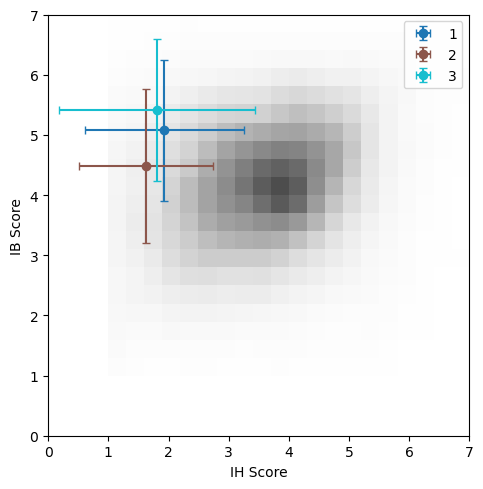

In [61]:
use_std = True

fig, ax = plt.subplots(figsize=(5, 5))

# Plot human KDE first using your existing function
human_kde(human_df=h2, ax=ax, alpha=0.7)


rounds = star_by_category['round'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(rounds)))

# For each round, get data for both categories and plot
for i, round in enumerate(rounds):
    # Get IH data for this round
    ih_data = star_by_category[(star_by_category['round'] == round) & 
                                 (star_by_category['category'] == 'IH')]
    
    # Get IB data for this round
    ib_data = star_by_category[(star_by_category['round'] == round) & 
                                 (star_by_category['category'] == 'IB')]
    
    # If we have both IH and IB data for this round
    if not ih_data.empty and not ib_data.empty:
        ih_mean = ih_data['mean'].values[0]
        if use_std:
            ih_sem = ih_data['std'].values[0]
        else: 
            ih_sem = ih_data['sem'].values[0]
        ib_mean = ib_data['mean'].values[0]
        if use_std:
            ib_sem = ib_data['std'].values[0]
        else:
            ib_sem = ib_data['sem'].values[0]
        
        # Plot the round point with error bars
        ax.errorbar(
            ih_mean, ib_mean,
            xerr=ih_sem, yerr=ib_sem, 
            fmt='o', color=colors[i], 
            label=round, capsize=3
        )

# Set axis labels and limits
ax.set_xlabel('IH Score')
ax.set_ylabel('IB Score')
ax.set_xlim(0, 7)
ax.set_ylim(0, 7)
ax.legend()

plt.tight_layout()
plt.show()